In [2]:
import numpy as np
import argparse
import cv2 as cv2
import matplotlib.pyplot as plt
from PIL import Image
from skimage.metrics import structural_similarity as compare_ssim

import os

In [3]:
image_size = (1920, 1080) # width, height
calibration_file = "calibration.npz"
test_image_file = ""


calibrationParams = np.load(calibration_file)
mtx = calibrationParams['mtx']
dist = calibrationParams['dist']

In [4]:
w = image_size[0]
h = image_size[1]

# beta = 
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

In [5]:
base_folder = "C:/Users/littl/OneDrive - University of Toronto/Winter 2025/CSC2530/Project/datasets/scans/camera sweep/bathroom_new_a/images"

laserOffFolder = os.path.join(base_folder, "laserOff")
laserOnFolder = os.path.join(base_folder, "laserOn")

laserOffImageBaseName = "capture_"
laserOnImageBaseName = "laser_"

numCaptures = len(os.listdir(laserOnFolder))


In [56]:
i = 0
laserOffImg = laserOffImageBaseName + str(i) +".png"
laserOffImgFile = os.path.join(laserOffFolder, laserOffImg)

laserOnImg = laserOnImageBaseName + str(i) +".png"
laserOnImgFile = os.path.join(laserOnFolder, laserOnImg)


img = cv2.imread(laserOffImgFile)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR )


laserImg = cv2.imread(laserOnImgFile)
laserImg = cv2.cvtColor(laserImg, cv2.COLOR_RGB2BGR )


imgGrey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
laserImgGrey = cv2.cvtColor(laserImg, cv2.COLOR_BGR2GRAY)


(score, diff) = compare_ssim(imgGrey, laserImgGrey, full=True)
diff = (diff * 255).astype("uint8")
print("SSIM: {}".format(score))

thresh = cv2.threshold(diff, 0, 255,
	cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]


SSIM: 0.8216197654988044


In [57]:
output_folder = "C:/Users/littl/OneDrive - University of Toronto/Winter 2025/CSC2530/Project/photos/laser_dot_detection_test"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)


cv2.imwrite(os.path.join(output_folder, "laserOff.png"), img)
cv2.imwrite(os.path.join(output_folder, "laserOn.png"), laserImg)
cv2.imwrite(os.path.join(output_folder, "diff.png"), diff)
cv2.imwrite(os.path.join(output_folder, "thresh.png"), thresh)

True

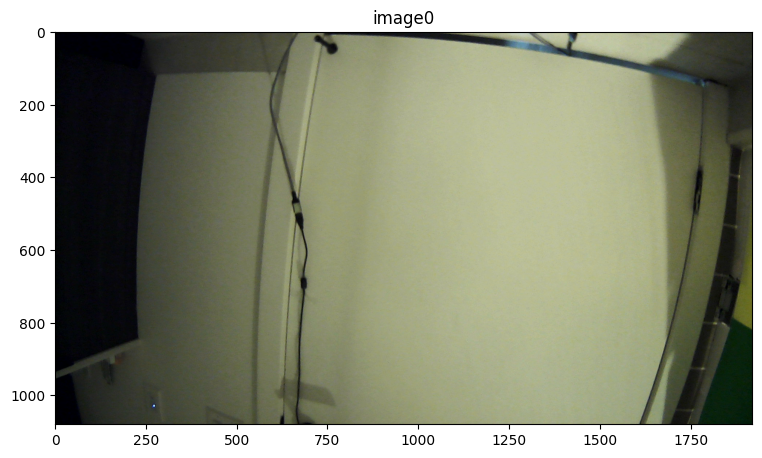

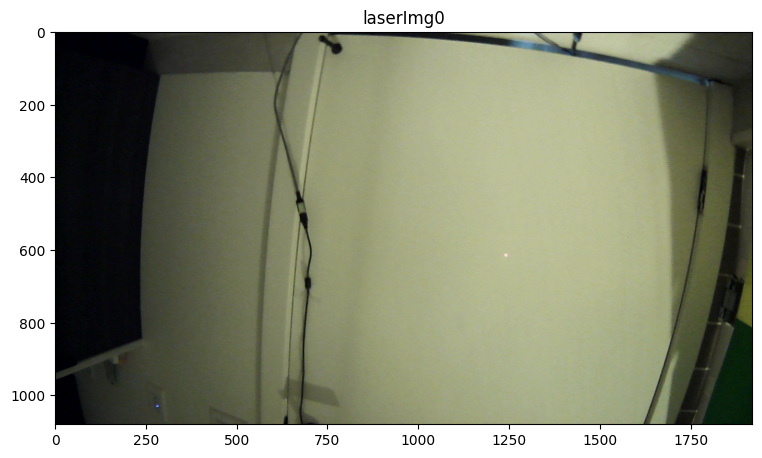

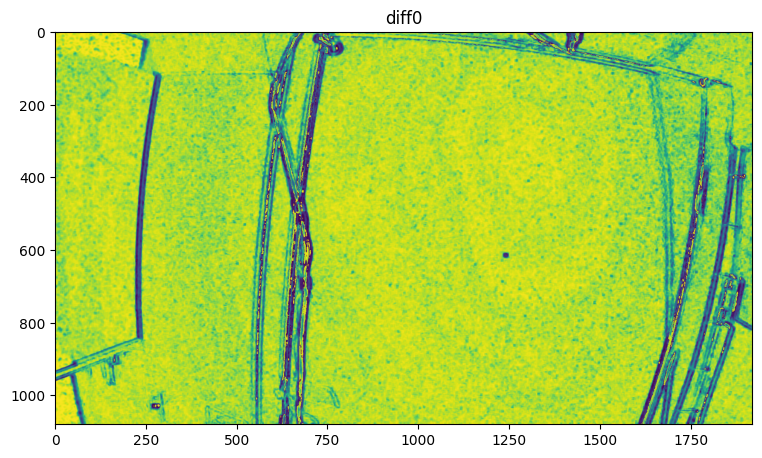

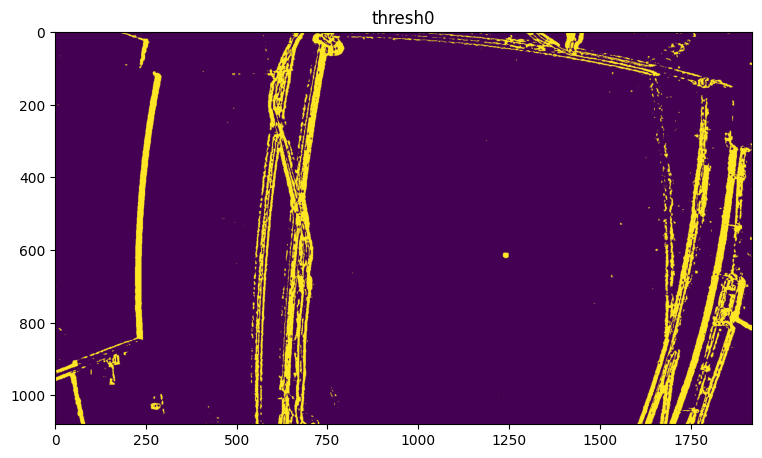

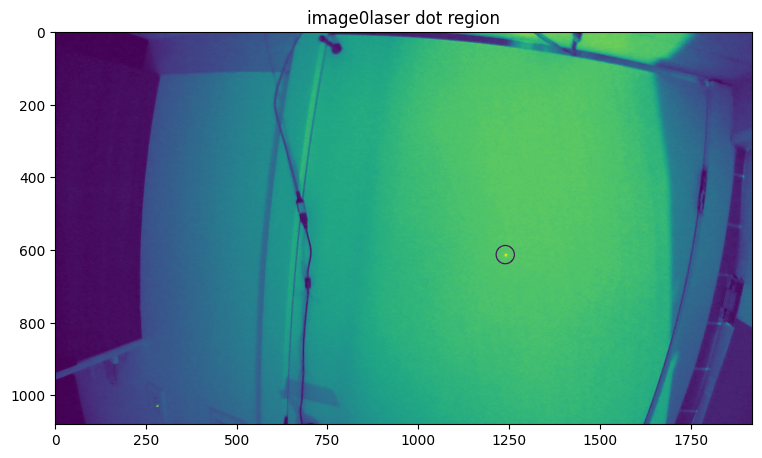

In [58]:

plt.figure(figsize=(9, 6))
title = "image" +str(i)
plt.title(title)
plt.imshow(img)

plt.figure(figsize=(9, 6))
title = "laserImg" +str(i)
plt.title(title)
plt.imshow(laserImg)

plt.figure(figsize=(9, 6))
title = "diff" +str(i)
plt.title(title)
plt.imshow(diff)

plt.figure(figsize=(9, 6))
title = "thresh" +str(i)
plt.title(title)
plt.imshow(thresh)

annotation_radius = 25
annotated = laserImgGrey.copy()
cv2.circle(annotated, maxLoc, annotation_radius, (0, 0, 255), 2)
plt.figure(figsize=(9, 6))
title = "image" +str(i) + "laser dot region"
plt.title(title)
plt.imshow(annotated)

In [93]:
blurRadius = 25
grayBlurred = cv2.GaussianBlur(imgGrey, (blurRadius, blurRadius), 0)
laserGrayBlurred = cv2.GaussianBlur(laserImgGrey, (blurRadius, blurRadius), 0)

(score, diffBlurred) = compare_ssim(grayBlurred, laserGrayBlurred, full=True)
diffBlurred = (diffBlurred * 255).astype("uint8")
print("SSIM: {}".format(score))

threshBlurred = cv2.threshold(diffBlurred, 0, 255,
	cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

SSIM: 0.9413827280930217


In [94]:

cv2.imwrite(os.path.join(output_folder, "diffBlurred.png"), diffBlurred)
cv2.imwrite(os.path.join(output_folder, "threshBlurred.png"), threshBlurred)

True

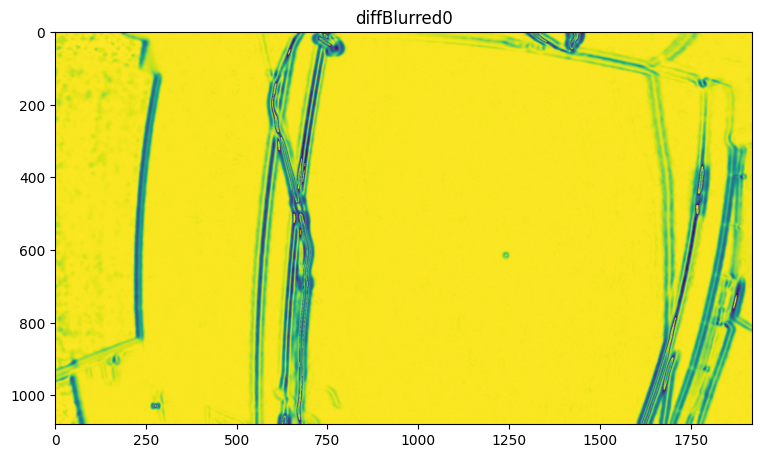

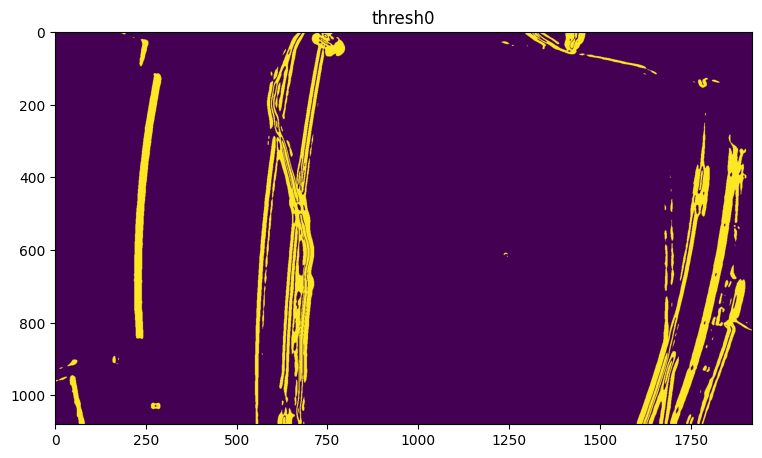

In [95]:

plt.figure(figsize=(9, 6))
title = "diffBlurred" +str(i)
plt.title(title)
plt.imshow(diffBlurred)

plt.figure(figsize=(9, 6))
title = "thresh" +str(i)
plt.title(title)
plt.imshow(threshBlurred)

# annotated = diffBlurred.copy()
# cv2.circle(annotated, maxLoc, radius, (255, 0, 0), 20)
# plt.figure(figsize=(9, 6))
# title = "diff blurred" +str(i) + "laser dot region"
# plt.title(title)
# plt.imshow(annotated)

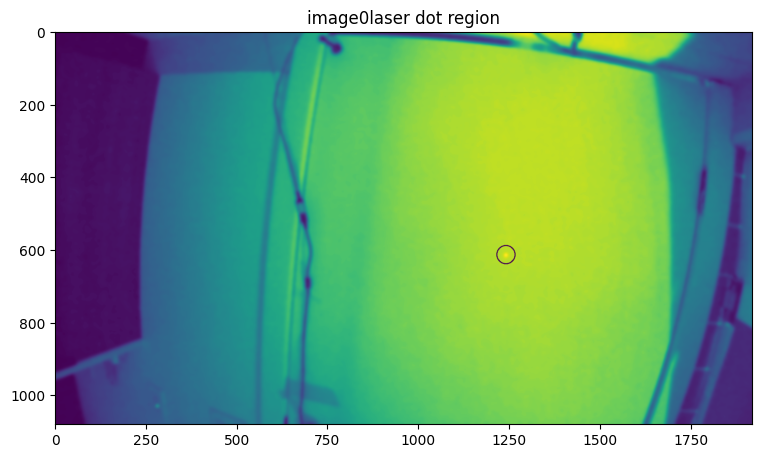

In [96]:
(minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(laserGrayBlurred)

# laserLocationPixelsRectified[i-1][0] = maxLoc[0]
# laserLocationPixelsRectified[i-1][1] = maxLoc[1]    

annotation_radius = 25
annotated = laserGrayBlurred.copy()
cv2.circle(annotated, maxLoc, annotation_radius, (0, 0, 255), 2)
plt.figure(figsize=(9, 6))
title = "image" +str(i) + "laser dot region"
plt.title(title)
plt.imshow(annotated)


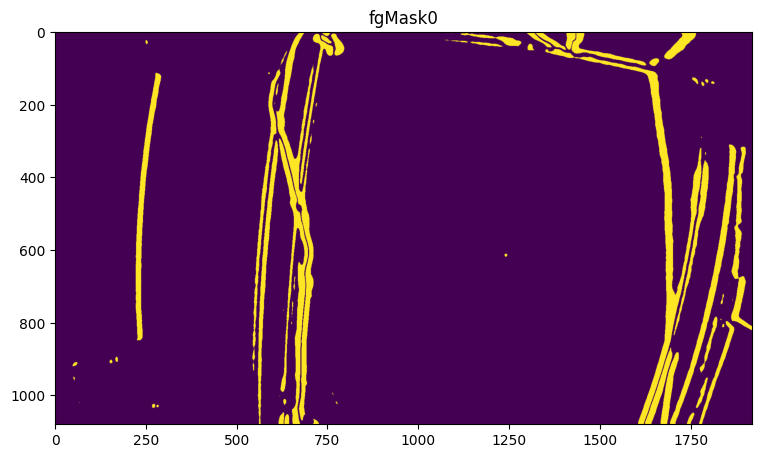

In [97]:
backSub = cv2.createBackgroundSubtractorMOG2()
backSub.apply(grayBlurred)

fgMask = backSub.apply(laserGrayBlurred)
plt.figure(figsize=(9, 6))
title = "fgMask" +str(i)
plt.title(title)
plt.imshow(fgMask)


In [98]:
# From https://learnopencv.com/video-stabilization-using-point-feature-matching-in-opencv/
# Pre-define transformation-store array
n_frames = 2
transforms = np.zeros((n_frames-1, 3), np.float32)
# laserGrayBlurred
# prev_pts = cv2.goodFeaturesToTrack(grayBlurred,
#                                      maxCorners=200,
#                                      qualityLevel=0.01,
#                                      minDistance=30,
#                                      blockSize=3)
# curr_pts, status, err = cv2.calcOpticalFlowPyrLK(grayBlurred, laserGrayBlurred, prev_pts, None) 
# # curr_pts, status, err = cv2.calcOpticalFlowPyrLK(imgGrey, laserImgGrey, prev_pts, None) 

prev_pts = cv2.goodFeaturesToTrack(imgGrey,
                                     maxCorners=200,
                                     qualityLevel=0.01,
                                     minDistance=30,
                                     blockSize=3)
# curr_pts, status, err = cv2.calcOpticalFlowPyrLK(grayBlurred, laserGrayBlurred, prev_pts, None) 
curr_pts, status, err = cv2.calcOpticalFlowPyrLK(imgGrey, laserImgGrey, prev_pts, None) 


idx = np.where(status==1)[0]
prev_pts = prev_pts[idx]
curr_pts = curr_pts[idx]

m, inliers = cv2.estimateAffine2D (prev_pts, curr_pts) #will only work with OpenCV-3 or less

# Extract traslation
dx = m[0,2]
dy = m[1,2]
# Extract rotation angle
da = np.arctan2(m[1,0], m[0,0])

print("Frame: " + str(i) + " -  Tracked points : " + str(len(prev_pts)))


Frame: 0 -  Tracked points : 124


In [101]:
print(m)
R = m[:,0:2]
print(R)
Rinv = np.transpose(R)
t = m[:,2]
tinv = -t

Minv = np.zeros((2,3))
Minv[:,0:2] = Rinv

Minv[:,2] = -t

print("Transform =", Minv)

grayBlurredwarped = cv2.warpAffine(grayBlurred, m, image_size)
laserWarped = cv2.warpAffine(laserGrayBlurred, Minv, image_size)

(score, diffBlurredTransformed) = compare_ssim(grayBlurredwarped, laserGrayBlurred, full=True)

# (score, diffBlurredTransformed) = compare_ssim(laserWarped, grayBlurred, full=True)


diffBlurredTransformed = (diffBlurredTransformed * 255).astype("uint8")
print("SSIM: {}".format(score))
# (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(laserGrayBlurred)

threshBlurredTransformed = cv2.threshold(diffBlurredTransformed, 0, 255,
	cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]



[[ 1.00055852e+00 -1.86581244e-03  1.21081696e+01]
 [ 1.39937582e-04  9.99785675e-01 -3.09686341e-01]]
[[ 1.00055852e+00 -1.86581244e-03]
 [ 1.39937582e-04  9.99785675e-01]]
Transform = [[ 1.00055852e+00  1.39937582e-04 -1.21081696e+01]
 [-1.86581244e-03  9.99785675e-01  3.09686341e-01]]
SSIM: 0.9850624737013494


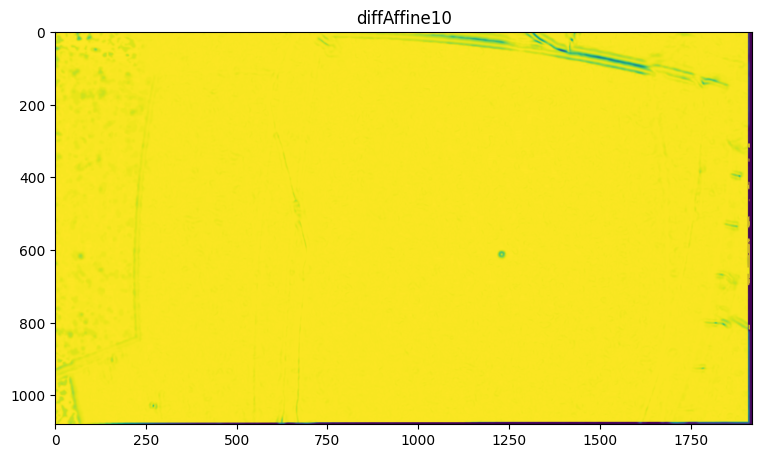

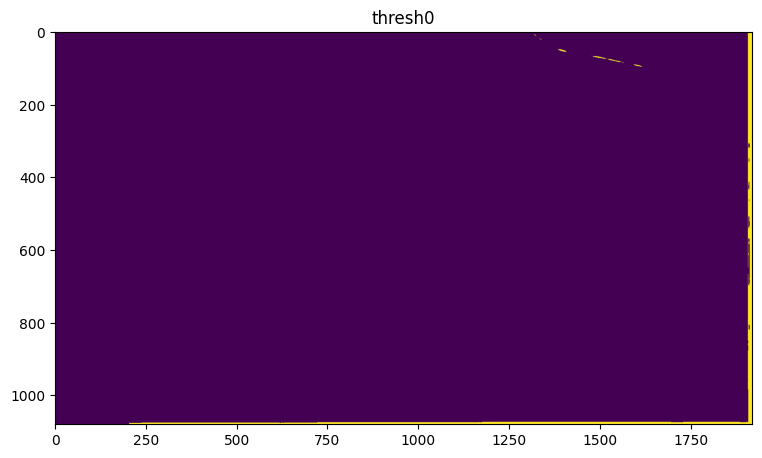

In [102]:

plt.figure(figsize=(9, 6))
title = "diffAffine1" +str(i)
plt.title(title)
plt.imshow(diffBlurredTransformed)

plt.figure(figsize=(9, 6))
title = "thresh" +str(i)
plt.title(title)
plt.imshow(threshBlurredTransformed)


In [66]:

cv2.imwrite(os.path.join(output_folder, "diffBlurredTransformed.png"), diffBlurredTransformed)
cv2.imwrite(os.path.join(output_folder, "threshBlurredTransformed.png"), threshBlurredTransformed)

True

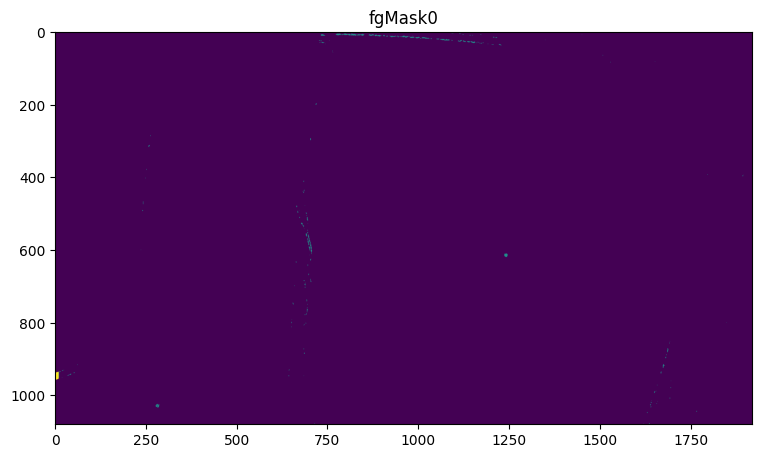

In [83]:
backSub = cv2.createBackgroundSubtractorMOG2()
backSub.apply(grayBlurredwarped)

fgMask = backSub.apply(laserGrayBlurred)
plt.figure(figsize=(9, 6))
title = "fgMask" +str(i)
plt.title(title)
plt.imshow(fgMask)

(1238, 614)


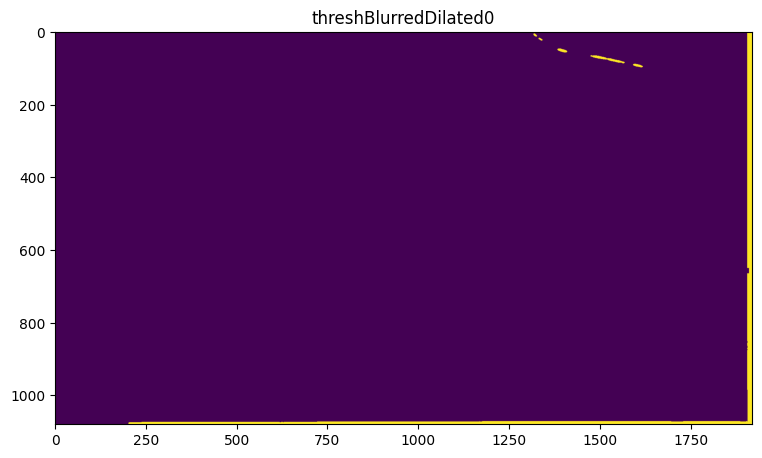

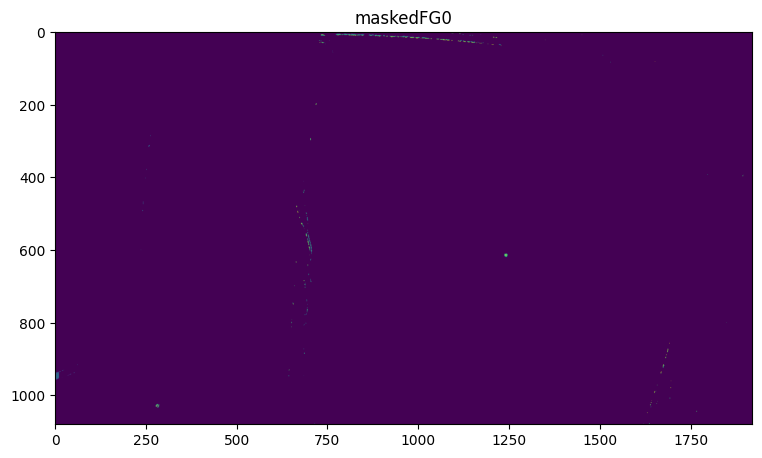

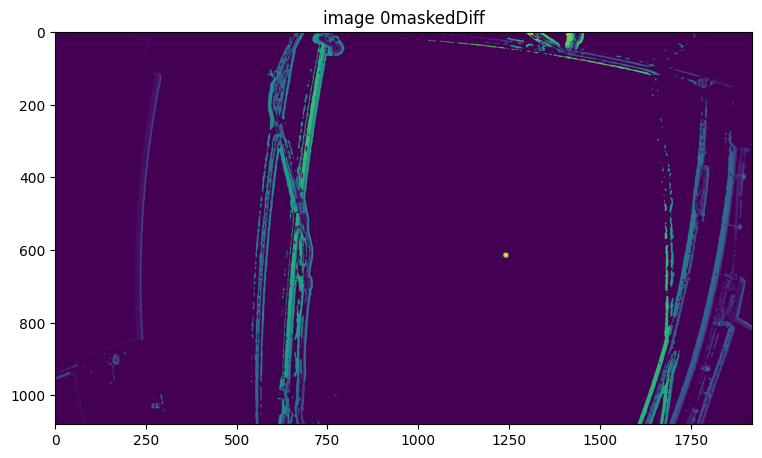

In [85]:

structuringElement = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
fgMaskDilated = cv2.dilate(fgMask,structuringElement) 

maskedFG = cv2.bitwise_and(laserGrayBlurred, fgMask)

maskedDiff = cv2.bitwise_and(laserGrayBlurred, threshBlurred)

(minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(masked)

print(maxLoc)

plt.figure(figsize=(9, 6))
title = "threshBlurredDilated" +str(i)
plt.title(title)
plt.imshow(threshBlurredDilated)

plt.figure(figsize=(9, 6))
title = "maskedFG" +str(i)
plt.title(title)
plt.imshow(maskedFG)

annotated = laserGrayBlurred.copy()
cv2.circle(annotated, maxLoc, annotation_radius, (0, 0, 255), 2)
plt.figure(figsize=(9, 6))
title = "image " +str(i) + "maskedDiff"
plt.title(title)
plt.imshow(maskedDiff)

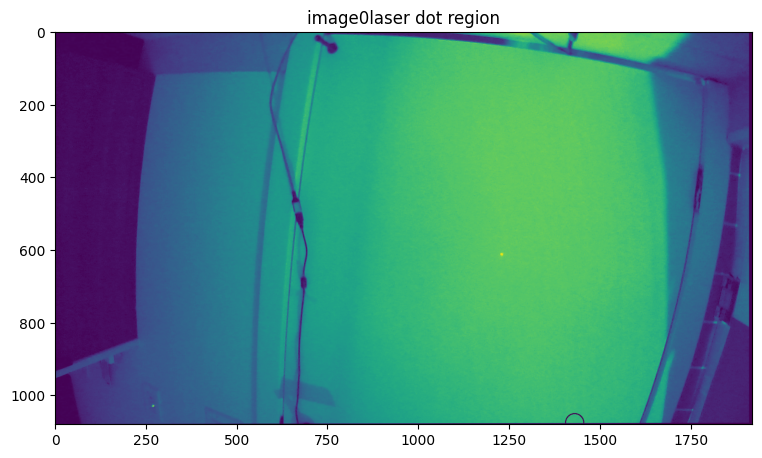

In [28]:
# warped = cv2.warpAffine(laserImgGrey, Minv, image_size)
masked = cv2.bitwise_and(warped, fgMaskDilated)

(minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(masked)

annotated = warped.copy()
cv2.circle(annotated, maxLoc, annotation_radius, (0, 0, 255), 2)
plt.figure(figsize=(9, 6))
title = "image" +str(i) + "laser dot region"
plt.title(title)
plt.imshow(annotated)

In [203]:
laserImg.shape

(1080, 1920, 3)

(282, 1032)


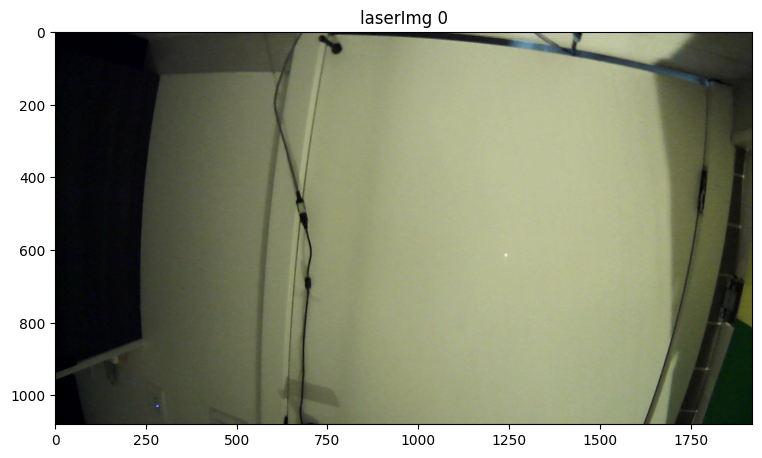

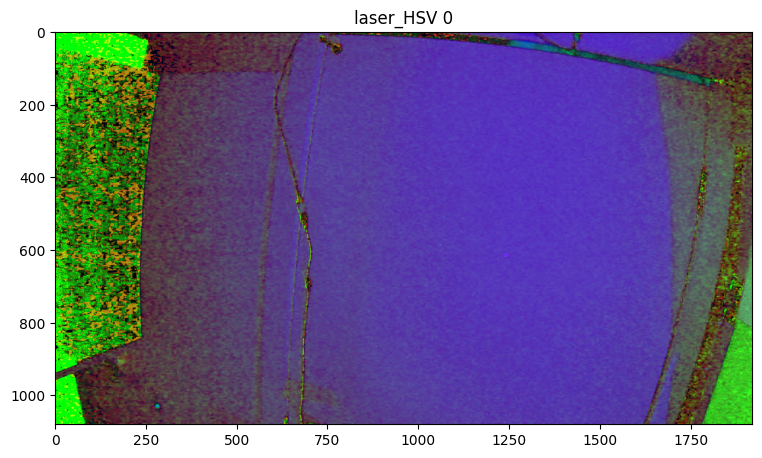

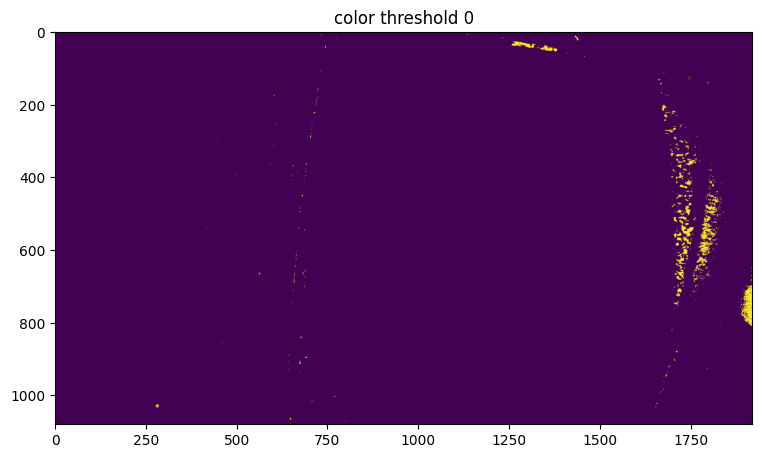

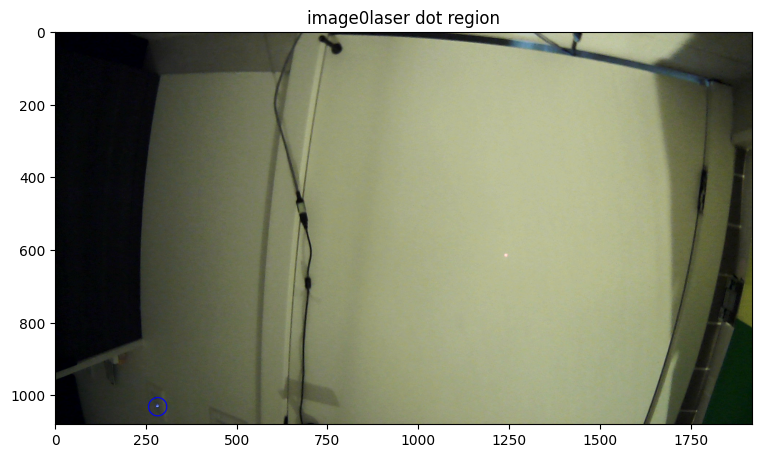

In [204]:
laser_HSV = cv.cvtColor(laserImg, cv2.COLOR_BGR2HSV)

lowerLimit = (0,100,100) # (10,255,255)
upperLimit = (179,255,255) # (160,100,100) # (179,255,255)

plt.figure(figsize=(9, 6))
title = "laserImg " +str(i)
plt.title(title)
plt.imshow(laserImg)

plt.figure(figsize=(9, 6))
title = "laser_HSV " +str(i)
plt.title(title)
plt.imshow(laser_HSV)

threshold = cv.inRange(laser_HSV, lowerLimit, upperLimit)

plt.figure(figsize=(9, 6))
title = "color threshold " +str(i)
plt.title(title)
plt.imshow(threshold)

RedMasked = cv2.bitwise_and(laserImgGrey, threshold)


(minVal, maxVal, minLoc, maxLoc) = cv.minMaxLoc(RedMasked)

print(maxLoc)

annotated = laserImg.copy()
cv.circle(annotated, maxLoc, radius, (0, 0, 255), 2)
plt.figure(figsize=(9, 6))
title = "image" +str(i) + "laser dot region"
plt.title(title)
plt.imshow(annotated)

# Image Rectification

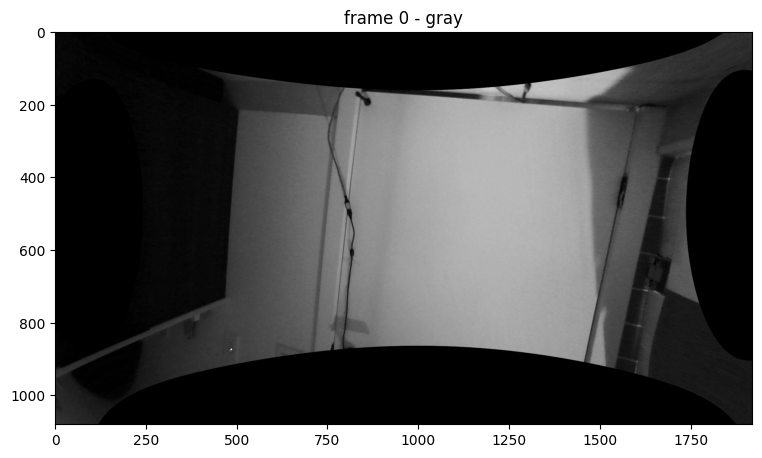

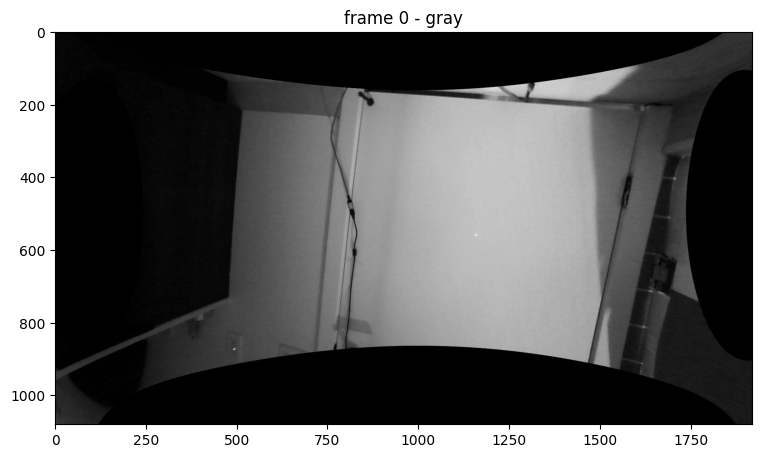

In [206]:
img_rectified = cv.undistort(img, mtx, dist, None, newcameramtx)
gray_rectified = cv.cvtColor(img_rectified, cv.COLOR_BGR2GRAY)
gray_rectified.shape
plt.figure(figsize=(9, 6))
plt.title(f"frame 0 - gray")
plt.imshow(gray_rectified, cmap='gray')

laser_rectified = cv.undistort(laserImg, mtx, dist, None, newcameramtx)
laser_gray_rectified = cv.cvtColor(laser_rectified, cv.COLOR_BGR2GRAY)

plt.figure(figsize=(9, 6))
plt.title(f"frame 0 - gray")
plt.imshow(laser_gray_rectified, cmap='gray')

In [132]:
print(laserOnFolder, laserOnImg)

C:/Users/littl/OneDrive - University of Toronto/Winter 2025/CSC2530/Project/datasets/scans/camera sweep/bathroom_comprehensive0_a/images\laserOn laser_0.png


In [133]:
print(laserOnImgFile)

C:/Users/littl/OneDrive - University of Toronto/Winter 2025/CSC2530/Project/datasets/scans/camera sweep/bathroom_comprehensive0_a/images\laserOn\laser_0.png
